In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 50
batch_size = 128
learning_rate = 1e-3

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # [B, 32, 14, 14]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [B, 64, 7, 7]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=7),  # [B, 128, 1, 1]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=7),  # [B, 64, 7, 7]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [B, 32, 14, 14]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # [B, 1, 28, 28]
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

# Training loop with Automatic Mixed Precision (AMP)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, images)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    # Adjust learning rate based on validation loss (here, training loss)
    scheduler.step(epoch_loss)

# Evaluate on test set
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        test_loss += loss.item() * images.size(0)
test_loss /= len(test_loader.dataset)
print(f'Test Reconstruction Loss: {test_loss:.4f}')


/Users/oha/BSvarautonet/venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/var/folders/rp/2yv9_hm14d5cbc5c4xsmjthh0000gn/T/ipykernel_25405/4254596776.py:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/Users/oha/BSvarautonet/venv/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/rp/2yv9_hm14d5cbc5c4xsmjthh0000gn/T/ipykernel_25405/4254596776.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/Users/oha/BSvarautonet/venv/lib/python3.11/site-packages/torch/amp/autocast_mode.py:265: UserWarning: Us

Epoch [1/50], Loss: 0.1400
Epoch [2/50], Loss: 0.0222
Epoch [3/50], Loss: 0.0175
Epoch [4/50], Loss: 0.0153
Epoch [5/50], Loss: 0.0137
Epoch [6/50], Loss: 0.0125
Epoch [7/50], Loss: 0.0116
Epoch [8/50], Loss: 0.0109
Epoch [9/50], Loss: 0.0104
Epoch [10/50], Loss: 0.0098
Epoch [11/50], Loss: 0.0094
Epoch [12/50], Loss: 0.0091
Epoch [13/50], Loss: 0.0087
Epoch [14/50], Loss: 0.0085
Epoch [15/50], Loss: 0.0082
Epoch [16/50], Loss: 0.0080
Epoch [17/50], Loss: 0.0077
Epoch [18/50], Loss: 0.0077
Epoch [19/50], Loss: 0.0075
Epoch [20/50], Loss: 0.0072
Epoch [21/50], Loss: 0.0072
Epoch [22/50], Loss: 0.0071
Epoch [23/50], Loss: 0.0069
Epoch [24/50], Loss: 0.0069
Epoch [25/50], Loss: 0.0067
Epoch [26/50], Loss: 0.0066
Epoch [27/50], Loss: 0.0066
Epoch [28/50], Loss: 0.0066
Epoch [29/50], Loss: 0.0065
Epoch [30/50], Loss: 0.0064
Epoch [31/50], Loss: 0.0064
Epoch [32/50], Loss: 0.0063
Epoch [33/50], Loss: 0.0062
Epoch [34/50], Loss: 0.0062
Epoch [35/50], Loss: 0.0062
Epoch [36/50], Loss: 0.0061
E

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

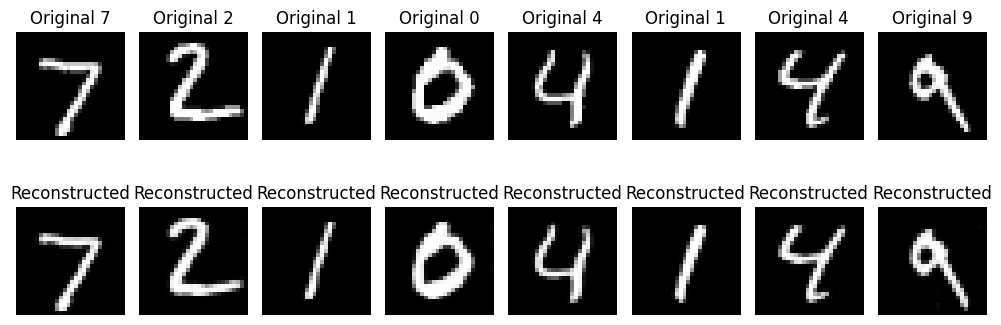

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img * 0.5 + 0.5  # Unnormalize to [0,1]
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.title(title)
    plt.axis('off')

# Assume test_loader, model, and device are defined elsewhere

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

# Get reconstructed images
with torch.no_grad():
    outputs = model(images)

# Display original images
plt.figure(figsize=(10, 4))
for idx in range(8):
    plt.subplot(2, 8, idx+1)
    imshow(images[idx], f'Original {labels[idx].item()}')

# Display reconstructed images
for idx in range(8):
    plt.subplot(2, 8, idx+9)
    imshow(outputs[idx], 'Reconstructed')

plt.tight_layout()
plt.show()

In [4]:
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"Test Reconstruction Loss: {test_loss}")

/Users/oha/BSvarautonet/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (28) must match the size of tensor b (128) at non-singleton dimension 3